In [2]:
!pip install pandas scipy pygsheets matplotlib

import os
import pygsheets
import matplotlib.pyplot as plt
from scipy.stats import norm
import csv
import pandas as pd
import numpy as np
import json
import math
import random

# Classes

## StgyApp

The main class for initializing everything and running simulations through reading prices in the dataset, updating all the parameters involved and executing the needed actions.

In [14]:
class StgyApp(object):

    def __init__(self, config):

        self.stk = config["stk"]
        self.total_costs_from_aave_n_dydx = 0
        self.total_pnl = 0
        self.gas_fees = 0

        # prices and intervals
        self.trigger_prices = {}
        self.intervals = {}

        # clients for data
        # self.binance_client = binance_client_.BinanceClient(config["binance_client"])
        # self.dydx_client = dydx_client.DydxClient(config["dydx_client"])
        # self.sm_interactor = sm_interactor.SmInteractor(config["sm_interactor"])
        # self.historical_data =

        # We create attributes to fill later
        self.aave = None
        self.aave_features = None
        self.aave_rates = None

        self.dydx = None
        self.dydx_features = None

        # self.volatility_calculator = None

        self.parameter_manager = ParameterManager()

        self.historical_data = None


        self.data_dumper = DataDamperNPlotter()

    def launch(self, config):
        # self.call_binance_data_loader()
        self.initialize_aave(config['initial_parameters']['aave'])
        self.initialize_dydx(config['initial_parameters']['dydx'])

    # call clients functions
    def get_historical_data(self, symbol, freq,
                                 initial_date, save):
        eth_historical = self.binance_client.get_all_binance(symbol=symbol, freq=freq,
                                                             initial_date=initial_date, save=save)
        # self.historical_data = eth_historical
        self.historical_data = eth_historical["close"]
        for i in range(len(self.historical_data)):
            self.historical_data[i] = float(self.historical_data[i])
        # self.load_intervals()

    # initialize classes
    def initialize_aave(self, config):
        # We initialize aave and dydx classes instances
        self.aave = Aave(config)
        # We load methods and attributes for aave and dydx to use later
        self.aave_features = {"methods": [func for func in dir(self.aave)
                                          if (callable(getattr(self.aave, func))) & (not func.startswith('__'))],
                              "attributes": {"values": list(self.aave.__dict__.values()),
                                             "keys": list(self.aave.__dict__.keys())}}
        # We create an attribute for historical data
        self.aave_historical_data = []

    def initialize_dydx(self, config):
        self.dydx = Dydx(config)
        self.dydx_features = {"methods": [func for func in dir(self.dydx)
                                          if (callable(getattr(self.dydx, func))) & (not func.startswith('__'))],
                              "attributes": {"values": list(self.dydx.__dict__.values()),
                                             "keys": list(self.dydx.__dict__.keys())}}
        self.dydx_historical_data = []

## Aave and DyDx modules

Modules with parameters for the protocols involved in the strategy (Aave and DyDx), methods for updating all the parameters given a new price read by the bot and methods for executing the actions needed.

### Aave

In [15]:
class Aave(object):

    def __init__(self, config):
        # assert self.dydx_class_instance == isinstance(dydx)
        # assert config['debt'] == config['collateral_eth'] * config['borrowed_pcg']
        self.market_price = config['market_price']

        self.entry_price = config['entry_price']

        self.collateral_eth_initial = config['collateral_eth']
        self.collateral_eth = config['collateral_eth']
        self.collateral_usdc = config['collateral_usdc']

        self.reserve_margin_eth = 0
        self.reserve_margin_usdc = 0

        self.borrowed_percentage = config['borrowed_pcg']
        self.usdc_status = config['usdc_status']

        self.debt = config['debt']
        self.debt_initial = config['debt']

        self.ltv = config['ltv']
        self.price_to_ltv_limit = config['price_to_ltv_limit']

        self.lending_rate = 0
        self.lending_rate_hourly = 0
        self.interest_on_lending_eth = 0  # aggregated fees
        self.interest_on_lending_usd = 0
        self.lending_fees_eth = 0 # fees between last 2 prices
        self.lending_fees_usd = 0

        self.borrowing_rate = 0
        self.borrowing_rate_hourly = 0
        self.interest_on_borrowing = 0 # aggregated fees
        self.borrowing_fees = 0 # fees between last 2 prices

        self.lend_minus_borrow_interest = 0

        self.costs = 0
        # self.historical = pd.DataFrame()
        # self.dydx_class_instance = dydx_class_instance
        # self.staked_in_protocol = stk

    # def update_costs(self):
    #     """
    #     it requires having called borrowing_fees_calc() in order to use updated values of last earned fees
    #     """
    #     # We have to substract lend_minus_borrow in order to increase the cost (negative cost means profit)
    #     self.costs = self.costs - self.lend_minus_borrow_interest

    def collateral_usd(self):
        return self.collateral_eth * self.market_price

    def update_debt(self):
        """
        it requires having called borrowing_fees_calc() in order to use updated values of last earned fees
        """
        self.debt = self.debt + self.borrowing_fees

    def update_collateral(self):
        """
        it requires having called lending_fees_calc() in order to use updated values of last earned fees
        """
        self.collateral_eth = self.collateral_eth + self.lending_fees_eth
        self.collateral_usdc = self.collateral_usd()

    def track_lend_borrow_interest(self):
        """
        it requires having called borrowing_fees_calc() and lending_fees_calc()
        in order to use updated values of last earned fees
        """
        self.lend_minus_borrow_interest = self.interest_on_lending_usd - self.interest_on_borrowing

    def lending_fees_calc(self, freq):
        self.simulate_lending_rate()
        self.lending_rate_freq = self.lending_rate / freq

        # fees from lending are added to collateral? YES
        # lending rate is applied to coll+lend fees every time or just to initial coll? COLL+LEND ie LAST VALUE
        self.lending_fees_eth = self.collateral_eth * self.lending_rate_freq
        self.lending_fees_usd = self.lending_fees_eth * self.market_price
        self.interest_on_lending_eth = self.interest_on_lending_eth + self.lending_fees_eth
        self.interest_on_lending_usd = self.interest_on_lending_usd + self.lending_fees_usd

    def borrowing_fees_calc(self, freq):
        self.simulate_borrowing_rate()
        self.borrowing_rate_freq = self.borrowing_rate / freq

        # fees from borrow are added to debt? YES
        # borrowing rate is applied to debt+borrow fees every time or just to initial debt? DEBT+BORROW ie LAST VALUE
        self.borrowing_fees = self.debt * self.borrowing_rate_freq
        self.interest_on_borrowing = self.interest_on_borrowing + self.borrowing_fees

    def simulate_lending_rate(self):
        # self.lending_rate = round(random.choice(list(np.arange(0.5/100, 1.5/100, 0.25/100))), 6)  # config['lending_rate']

        # best case
        # self.lending_rate = 1.5 / 100

        # worst case
        self.lending_rate = 0.5 / 100

    def simulate_borrowing_rate(self):
        # self.borrowing_rate = round(random.choice(list(np.arange(1.5/100, 2.5/100, 0.25/100))), 6)  # config['borrowing_rate']

        # best case
        # self.borrowing_rate = 1.5/100

        # worst case
        self.borrowing_rate = 2.5/100

    def ltv_calc(self):
        if self.collateral_usd() == 0:
            return 0
        else:
            return self.debt / self.collateral_usd()

    def price_to_liquidation(self, dydx_class_instance):
        return self.entry_price - (dydx_class_instance.short_pnl()
                                   + self.debt - self.lend_minus_borrow_interest) / self.collateral_eth

    def price_to_ltv_limit_calc(self):
        return round(self.entry_price * self.borrowed_percentage / self.ltv_limit(), 3)

    def buffer_for_repay(self):
        return 0.01

    def ltv_limit(self):
        return 0.5

    # Actions to take
    def return_usdc(self, stgy_instance):
        gas_fees = stgy_instance.gas_fees
        time = 0
        if self.usdc_status:
            # simulate 2min delay for tx
            # update parameters
            # AAVE parameters
            self.usdc_status = False
            # self.collateral_eth = 0
            # self.collateral_usdc = 0
            self.debt = 0
            self.ltv = 0
            self.price_to_ltv_limit = 0
            # self.lending_rate = 0
            # self.borrowing_rate = 0

            # fees
            self.costs = self.costs + gas_fees

            time = 1
        return time

    def repay_aave(self, stgy_instance):
        gas_fees = stgy_instance.gas_fees
        dydx_class_instance = stgy_instance.dydx
        # aave_class_instance = stgy_instance.aave
        # dydx_client_class_instance = stgy_instance.dydx_client
        #
        time = 0
        if self.usdc_status:
            # update parameters
            short_size_for_debt = self.debt / (self.market_price - dydx_class_instance.short_entry_price)
            new_short_size = dydx_class_instance.short_size - short_size_for_debt

            # pnl_for_debt = dydx_class_instance.pnl()
            # We have to repeat the calculations for pnl and notional methods, but using different size_eth
            pnl_for_debt = short_size_for_debt * (self.market_price - dydx_class_instance.short_entry_price)
            self.debt = self.debt - pnl_for_debt
            self.ltv = self.ltv_calc()

            self.price_to_ltv_limit = round(self.entry_price * (self.debt / self.collateral_usdc) / self.ltv_limit(), 3)
            self.costs = self.costs + gas_fees

            dydx_class_instance.short_size = new_short_size
            dydx_class_instance.short_notional = dydx_class_instance.short_notional_calc()
            dydx_class_instance.short_equity = dydx_class_instance.short_equity_calc()
            dydx_class_instance.short_leverage = dydx_class_instance.short_leverage_calc()
            dydx_class_instance.short_pnl = dydx_class_instance.short_pnl_calc()
            # dydx_class_instance.price_to_liquidation = \
            #     dydx_class_instance.price_to_liquidation_calc(dydx_client_class_instance)

            # fees
            # withdrawal_fees = pnl_for_debt * dydx_class_instance.withdrawal_fees
            dydx_class_instance.simulate_maker_taker_fees()
            notional_for_fees = abs(short_size_for_debt) * self.market_price
            dydx_class_instance.short_costs = dydx_class_instance.short_costs \
                                              + dydx_class_instance.maker_taker_fees * notional_for_fees \
                                              + pnl_for_debt * dydx_class_instance.withdrawal_fees

            # Note that a negative self.debt is actually a profit
            # We update the parameters
            if self.debt > 0:
                self.usdc_status = True
            else:
                self.usdc_status = False
            # simulate 2min delay for tx
            time = 1
        return time

### DyDx

In [16]:
class Dydx(object):

    def __init__(self, config):
        # assert aave_class == isinstance(aave)
        self.market_price = config['market_price']

        # Short attributes
        self.short_entry_price = config['entry_price']
        self.short_size = config['short_size']
        self.short_collateral = config['collateral']
        self.short_notional = config['notional']
        self.short_equity = config['equity']
        self.short_leverage = config['leverage']
        self.short_pnl = config['pnl']
        self.short_collateral_status = config['collateral_status']
        self.short_status = config['short_status']
        self.short_costs = 0

        # Long attributes
        self.long_entry_price = config['entry_price']
        self.long_size = config['short_size']
        self.long_notional = config['notional']
        # self.long_equity = config['equity']
        # self.long_leverage = config['leverage']
        self.long_pnl = config['pnl']
        self.long_status = config['short_status']
        self.long_costs = 0

        self.order_status = True
        self.withdrawal_fees = 0.01 / 100
        self.funding_rates = 0
        self.maker_taker_fees = 0
        self.maker_fees_counter = 0


    # auxiliary functions
    # Short methods
    def short_pnl_calc(self):
        return self.short_size * (self.market_price - self.short_entry_price)

    def short_notional_calc(self):
        return abs(self.short_size) * self.market_price

    def short_equity_calc(self):
        return self.short_collateral + self.short_pnl_calc()

    def short_leverage_calc(self):
        if self.short_equity_calc() == 0:
            return 0
        else:
            return self.short_notional_calc() / self.short_equity_calc()

    # Long methods
    def long_pnl_calc(self):
        return self.long_size * (self.market_price - self.long_entry_price)

    def long_notional_calc(self):
        return abs(self.long_size) * self.market_price

    def price_to_repay_aave_debt_calc(self, pcg_of_debt_to_cover, aave_class_instance):
        return self.short_entry_price \
               + aave_class_instance.debt * pcg_of_debt_to_cover / self.short_size

    @staticmethod
    def price_to_liquidation_calc(dydx_client_class_instance):
        return dydx_client_class_instance.dydx_margin_parameters["liquidation_price"]

    def add_funding_rates(self):
        self.simulate_funding_rates()
        self.short_costs = self.short_costs - self.funding_rates * self.short_notional

    def simulate_funding_rates(self):
        # self.funding_rates = round(random.choice(list(np.arange(-0.0075/100, 0.0075/100, 0.0005/100))), 6)

        # best case
        # self.funding_rates = 0.0075 / 100

        # average -0.00443%

        # worst case
        self.funding_rates = -0.0075 / 100

    def simulate_maker_taker_fees(self):
        # We add a counter for how many times we call this function
        # i.e. how many times we open and close the short
        self.maker_fees_counter += 1
        # self.maker_taker_fees = round(random.choice(list(np.arange(0.01/100, 0.035/100, 0.0025/100))), 6)

        # maker fees
        self.maker_taker_fees = 0.05 / 100  # <1M
        # self.maker_taker_fees = 0.04 / 100 # <5M
        # self.maker_taker_fees = 0.035 / 100 # <10M
        # self.maker_taker_fees = 0.03 / 100 # <50M
        # self.maker_taker_fees = 0.025 / 100 # <200M
        # self.maker_taker_fees = 0.02 / 100  # >200M

    # Actions to take
    def remove_collateral(self, stgy_instance):
        self.cancel_order()
        time = 0
        if self.short_collateral_status:
            self.short_collateral_status = False
            withdrawal_fees = self.short_collateral * self.withdrawal_fees
            self.short_collateral = 0
            # self.price_to_liquidation = 0

            # fees
            self.short_costs = self.short_costs + withdrawal_fees

            time = 1
        return time

    def open_short(self, stgy_instance):
        aave_class_instance = stgy_instance.aave
        # dydx_client_class_instance = stgy_instance.dydx_client
        if (not self.short_status) and self.order_status:
            self.short_status = True
            self.short_entry_price = self.market_price
            self.short_size = -aave_class_instance.collateral_eth_initial
            # self.collateral = aave_class_instance.debt_initial
            self.short_notional = self.short_notional_calc()
            self.short_equity = self.short_equity_calc()
            self.short_leverage = self.short_leverage_calc()
            # Simulate maker taker fees
            self.simulate_maker_taker_fees()
            # Add costs
            self.short_costs = self.short_costs + self.maker_taker_fees * self.short_notional
        return 0

    def close_short(self, stgy_instance):
        if self.short_status:
            self.short_notional = self.short_notional_calc()
            self.short_equity = self.short_equity_calc()
            self.short_leverage = self.short_leverage_calc()
            self.short_pnl = self.short_pnl_calc()
            stgy_instance.total_pnl = stgy_instance.total_pnl + self.short_pnl
            # We update short parameters after the calculation of pnl
            self.short_entry_price = 0
            self.short_status = False
            self.short_size = 0
            self.simulate_maker_taker_fees()
            self.short_costs = self.short_costs + self.maker_taker_fees * self.short_notional
        return 0

    def open_long(self, stgy_instance):
        aave_class_instance = stgy_instance.aave
        # dydx_client_class_instance = stgy_instance.dydx_client
        if not self.long_status:
            self.long_status = True
            self.long_entry_price = self.market_price
            self.long_size = aave_class_instance.collateral_eth_initial
            # self.collateral = aave_class_instance.debt_initial
            self.long_notional = self.long_notional_calc()
            # Simulate maker taker fees
            self.simulate_maker_taker_fees()
            # Add costs
            self.long_costs = self.long_costs + self.maker_taker_fees * self.long_notional
        return 0

    def close_long(self, stgy_instance):
        if self.long_status:
            self.long_notional = self.long_notional_calc()
            self.long_pnl = self.long_pnl_calc()
            stgy_instance.total_pnl = stgy_instance.total_pnl + self.long_pnl
            # We update short parameters after the calculation of pnl
            self.long_entry_price = 0
            self.long_status = False
            self.long_size = 0
            self.simulate_maker_taker_fees()
            self.long_costs = self.long_costs + self.maker_taker_fees * self.long_notional
        return 0

    def place_order(self, price):
        self.order_status = True
        # self.

    def cancel_order(self):
        self.order_status = False

## ParameterManager Module

This module is in charge of defining trigger points and intervals, updating parameters given a new price, and fining/executing the needed actions.

In [17]:
class ParameterManager(object):
    # auxiliary functions
    @staticmethod
    def define_target_prices(stgy_instance, slippage, vol, floor, pcg):
        mu = vol[0]
        sigma = vol[1]
        roof = floor * (1+pcg)
        start = (roof+floor)/2
        ##########################################################
        # We define the intervals
        list_of_intervals = ["roof",
                             "start",
                             "floor"]
        list_of_trigger_prices = [roof,
                                  start,
                                  floor]
        # We define/update trigger prices
        for i in range(len(list_of_intervals)):
            interval_name = list_of_intervals[i]
            trigger_price = list_of_trigger_prices[i]
            stgy_instance.trigger_prices[interval_name] = trigger_price

    @staticmethod
    def calc_vol(last_date, data):
        periods_for_vol = [6 * 30 * 24 * 60, 3 * 30 * 24 * 60, 1 * 30 * 24 * 60]
        last_six_months = data.loc[:last_date][-periods_for_vol[0]:]
        for i in range(len(periods_for_vol)):
            N = periods_for_vol[i]
            log_returns = np.log(last_six_months[-N:]['close']) - np.log(last_six_months[-N:]['close'].shift(1))
            globals()['sigma_' + str(i)] = log_returns.ewm(alpha=0.8, adjust=False).std().mean()
            globals()['mu_' + str(i)] = log_returns.ewm(alpha=0.8, adjust=False).mean().mean()
        mu = mu_0 * 0.1 + mu_1 * 0.3 + mu_2 * 0.6
        sigma = sigma_0 * 0.1 + sigma_1 * 0.3 + sigma_2 * 0.6
        vol = [mu, sigma]
        return vol

    @staticmethod
    # Checking and updating data
    def update_parameters(stgy_instance, new_market_price):
        # AAVE
        stgy_instance.aave.market_price = new_market_price
        # Before updating collateral and debt we have to calculate last earned fees + update interests earned until now
        # As we are using hourly data we have to convert anual rate interest into hourly interest, therefore freq=365*24
        stgy_instance.aave.lending_fees_calc(freq=365 * 24 * 60)
        stgy_instance.aave.borrowing_fees_calc(freq=365 * 24 * 60)
        # We have to execute track_ first because we need the fees for current collateral and debt values
        stgy_instance.aave.track_lend_borrow_interest()
        # stgy_instance.aave.update_costs() # we add lend_borrow_interest to costs
        stgy_instance.aave.update_debt()  # we add the last borrowing fees to the debt
        stgy_instance.aave.update_collateral()  # we add the last lending fees to the collateral and update both eth and usd values
        stgy_instance.aave.ltv = stgy_instance.aave.ltv_calc()

        # DYDX
        stgy_instance.dydx.market_price = new_market_price
        # Short updates
        stgy_instance.dydx.short_notional = stgy_instance.dydx.short_notional_calc()
        stgy_instance.dydx.short_equity = stgy_instance.dydx.short_equity_calc()
        stgy_instance.dydx.short_leverage = stgy_instance.dydx.short_leverage_calc()
        stgy_instance.dydx.short_pnl = stgy_instance.dydx.short_pnl_calc()
        # Long updates
        stgy_instance.dydx.long_notional = stgy_instance.dydx.long_notional_calc()
        stgy_instance.dydx.long_pnl = stgy_instance.dydx.long_pnl_calc()

    @staticmethod
    def reset_costs(stgy_instance):
        # We reset the costs in order to always start in 0
        stgy_instance.aave.costs = 0
        stgy_instance.dydx.short_costs = 0
        stgy_instance.dydx.long_costs = 0

    def find_scenario(self, stgy_instance, market_price, previous_market_price):
        self.simulate_fees(stgy_instance)
        roof = stgy_instance.trigger_prices['roof']
        start = stgy_instance.trigger_prices['start']
        floor = stgy_instance.trigger_prices['floor']
        # Case P crossing roof upwards: Close short
        if (previous_market_price <= roof) and (market_price >= roof):
            if stgy_instance.dydx.short_status:
                stgy_instance.dydx.close_short(stgy_instance)
        # Case P crossing start in any direction: Start both
        elif ((previous_market_price <= start) and (market_price >= start)) or ((previous_market_price >= start) and (market_price <= start)):
                stgy_instance.dydx.open_long(stgy_instance)
                stgy_instance.dydx.open_short(stgy_instance)
        # Case P crossing floor downwards: Close Long
        elif (previous_market_price >= floor) and (market_price <= floor):
            if stgy_instance.dydx.long_status:
                stgy_instance.dydx.close_long(stgy_instance)

    @staticmethod
    def simulate_fees(stgy_instance):
        # stgy_instance.gas_fees = round(random.choice(list(np.arange(1, 10, 0.5))), 6)

        # best case
        # stgy_instance.gas_fees = 1

        # stgy_instance.gas_fees = 3

        # stgy_instance.gas_fees = 6

        # worst case
        stgy_instance.gas_fees = 10

    @staticmethod
    def update_pnl(stgy_instance):
        stgy_instance.total_pnl = stgy_instance.total_pnl - stgy_instance.aave.costs - stgy_instance.dydx.short_costs - stgy_instance.dydx.long_costs + stgy_instance.aave.lending_fees_usd - stgy_instance.aave.borrowing_fees

    @staticmethod
    def add_costs(stgy_instance):
        stgy_instance.total_costs_from_aave_n_dydx = stgy_instance.total_costs_from_aave_n_dydx \
                                                     + stgy_instance.aave.costs + stgy_instance.dydx.short_costs +stgy_instance.dydx.long_costs

## DataDamperNPlotter Module

This module will write the results and is also used for plotting (for analysis porpuses).

In [18]:
class DataDamperNPlotter:
    def __init__(self):
        self.historical_data = None

    @staticmethod
    def write_data(stgy_instance,
                   period, floor,
                   sheet=False):
        aave_instance = stgy_instance.aave
        dydx_instance = stgy_instance.dydx
        data_aave = []
        data_dydx = []
        aave_wanted_keys = [
            "market_price",
            # "interval_current",
            "entry_price",
            "collateral_eth",
            "usdc_status",
            "debt",
            "ltv",
            "lending_rate",
            "interest_on_lending_usd",
            "borrowing_rate",
            "interest_on_borrowing",
            "lend_minus_borrow_interest",
            "costs"]

        for i in range(len(aave_instance.__dict__.values())):
            if list(aave_instance.__dict__.keys())[i] in aave_wanted_keys:
                    data_aave.append(str(list(aave_instance.__dict__.values())[i]))
        for i in range(len(dydx_instance.__dict__.values())):
                data_dydx.append(str(list(dydx_instance.__dict__.values())[i]))
        # We add the index number of the appareance of market price in historical_data.csv order to find useful test values quicker
        data_aave.append(stgy_instance.gas_fees)
        data_aave.append(stgy_instance.total_costs_from_aave_n_dydx)
        data_aave.append(stgy_instance.total_pnl)

        data_dydx.append(stgy_instance.gas_fees)
        data_dydx.append(stgy_instance.total_costs_from_aave_n_dydx)
        data_dydx.append(stgy_instance.total_pnl)
        if sheet == True:
            gc = pygsheets.authorize(service_file=
                                     'stgy-1-simulations-e0ee0453ddf8.json')
            sh = gc.open('aave/dydx simulations')
            sh[0].append_table(data_aave, end=None, dimension='ROWS', overwrite=False)
            sh[1].append_table(data_dydx, end=None, dimension='ROWS', overwrite=False)
        else:
            path_to_aave = 'Files/From_%s_to_%s_open_close_at_%s/aave_results.csv' % (
            period[0], period[1], int(floor))  # int(stgy_instance.trigger_prices['open_close']))
            path_to_dydx = 'Files/From_%s_to_%s_open_close_at_%s/dydx_results.csv' % (
            period[0], period[1], int(floor))  # int(stgy_instance.trigger_prices['open_close']))
            with open(path_to_aave, 'a') as file:
                writer = csv.writer(file, lineterminator='\n')
                writer.writerow(data_aave)
            with open(path_to_dydx, 'a',
                      newline='', encoding='utf-8') as file:
                writer = csv.writer(file, lineterminator='\n')
                writer.writerow(data_dydx)

    @staticmethod
    def delete_results(period, floor):
        file_aave = 'Files/From_%s_to_%s_open_close_at_%s/aave_results.csv' % (
        period[0], period[1], int(floor))  # int(stgy_instance.trigger_prices['open_close']))
        file_dydx = 'Files/From_%s_to_%s_open_close_at_%s/dydx_results.csv' % (
        period[0], period[1], int(floor))  # int(stgy_instance.trigger_prices['open_close']))
        if (os.path.exists(file_aave) and os.path.isfile(file_aave)):
            os.remove(file_aave)
        if (os.path.exists(file_dydx) and os.path.isfile(file_dydx)):
            os.remove(file_dydx)

    @staticmethod
    def add_header(period, floor):
        aave_headers = [
            "market_price",
            "entry_price",
            "collateral_eth",
            "usdc_status",
            "debt",
            "ltv",
            "lending_rate",
            "interest_on_lending_usd",
            "borrowing_rate",
            "interest_on_borrowing",
            "lend_minus_borrow_interest",
            "costs",
            "gas_fees",
            "total_costs_from_aave_n_dydx",
            "total_stgy_pnl"]
        dydx_headers = [
            "market_price",
            "short_entry_price",
            "short_size",
            "short_collateral",
            "short_notional",
            "short_equity",
            "short_leverage",
            "short_pnl",
            "short_collateral_status",
            "short_status",
            "short_costs",
            "long_entry_price",
            "long_size",
            "long_notional",
            "long_pnl",
            "long_status",
            "long_costs",
            "order_status",
            "withdrawal_fees",
            "funding_rates",
            "maker_taker_fees",
            "maker_fees_counter",
            "gas_fees",
            "total_costs_from_aave_n_dydx",
            "total_stgy_pnl"]

        path_to_aave = 'Files/From_%s_to_%s_open_close_at_%s/aave_results.csv' % (
        period[0], period[1], int(floor))  # int(stgy_instance.trigger_prices['open_close']))
        path_to_dydx = 'Files/From_%s_to_%s_open_close_at_%s/dydx_results.csv' % (
        period[0], period[1], int(floor))  # int(stgy_instance.trigger_prices['open_close']))
        with open(path_to_aave, 'a') as file:
            writer = csv.writer(file, lineterminator='\n')
            writer.writerow(aave_headers)
        with open(path_to_dydx, 'a',
                  newline='', encoding='utf-8') as file:
            writer = csv.writer(file, lineterminator='\n')
            writer.writerow(dydx_headers)

## Simulations

Given that shorting involve executing too many txs, let's try combining it with a long position to get a delta neutral final strategy and at the same time giving room to the price to move laterally.

The idea is to 
- open a short and a long position (both leveraged) using the debt from AAVE at a certain price called start
- if price reaches some point start + delta we will close the short position and stay with the long only
- if price reaches floor (= start - delta) we will close the long and stay only with the short

First of all lets read the dataset containing prices for ETH in minutes basis from 2019-09-01 to 2022-09-01.

In [3]:
# Track historical data
# symbol = 'ETHUSDC'
# freq = '1m'
# initial_date = "1 Jan 2019"
# stgy.get_historical_data(symbol=symbol, freq=freq,
#                               initial_date=initial_date, save=True)

# Load historical data if previously tracked and saved

historical_data = pd.read_csv("Files/ETHUSDC-1m-data_since_1 Sep 2019.csv")
# # assign data to stgy instance + define index as dates
timestamp = pd.to_datetime(historical_data['timestamp'])
historical_data = pd.DataFrame(historical_data["close"], columns=['close'])
historical_data.index = timestamp
#
# #######################################################


In order to test pnl/costs of the whole strategy let's find a period of time and a relevant price (i.e. a price that is crossed many times).

In [9]:
# Period of Simulations
period = ["2020-05-01","2020-11-01"]
data = historical_data.loc[period[0]+' 00:00:00':period[1]+' 00:00:00']


Let's analyze historical 6month weighted volatility to check if 5% is enough space to move between OCs. We will compare 
$$5\% \text{ vs } (1+slippgae)(1+\mu+2\sigma),$$
where $\sigma=vol$.

In [10]:
# First we calculate weighted vol
last_date = "2021-06-01"
slippage = 0.0005
periods_for_vol = [6*30*24*60, 3*30*24*60, 1*30*24*60]
data = historical_data.loc[:last_date][-periods_for_vol[0]:]
for i in range(len(periods_for_vol)):
    N = periods_for_vol[i]
    log_returns = np.log(data[-N:]['close']) - np.log(data[-N:]['close'].shift(1))
    globals()['sigma_'+str(i)] = log_returns.ewm(alpha=0.8, adjust=False).std().mean()
    globals()['mu_'+str(i)] = log_returns.ewm(alpha=0.8, adjust=False).mean().mean()
    globals()['mu_max_'+str(i)] = log_returns.ewm(alpha=0.8, adjust=False).mean().max()
    globals()['mu_min_'+str(i)] = log_returns.ewm(alpha=0.8, adjust=False).mean().min()
vol = sigma_0 * 0.1 + sigma_1 * 0.3 + sigma_2 * 0.6
mu = mu_0 * 0.1 + mu_1 * 0.3 + mu_2 * 0.6
print("weighted mu: ", str(mu*100)+'%')
print("weighted sigmas: ", str(vol*100)+'%')
print("[min_6m_change, max_6m_change]: ", [str(mu_min_0*100)+'%', str(mu_max_0*100)+'%'])
print("avg movement: (1+slip)(1+mu+2vol): ", str((1+slippage)*(1+mu+6*vol)*100-100)+'%')
# vol, mu, mu_max_0, mu_min_0, mu_0, (1+slippage)*(1+mu+2*vol)

weighted mu:  1.4462763455814235e-05%
weighted sigmas:  0.17999807112824498%
[min_6m_change, max_6m_change]:  ['-6.786594905713236%', '9.135956592119358%']
avg movement: (1+slip)(1+mu+2vol):  1.1305428909776651%


We conclude that 5% is several times higher than the common movement of price within 1 minute, so we should have spaced enough OCs to choose if we executed too many txs.

In [ ]:
# normal_std = std
# medium_std = 2*std
# high_std = 4*std
# extreme_std = 6*std
# normal_std, medium_std, high_std, extreme_std

(0.0005989101310066664,
 0.0011978202620133327,
 0.0023956405240266655,
 0.0035934607860399984)

Let's find such a relevant price manually by taking a look at the price plot.

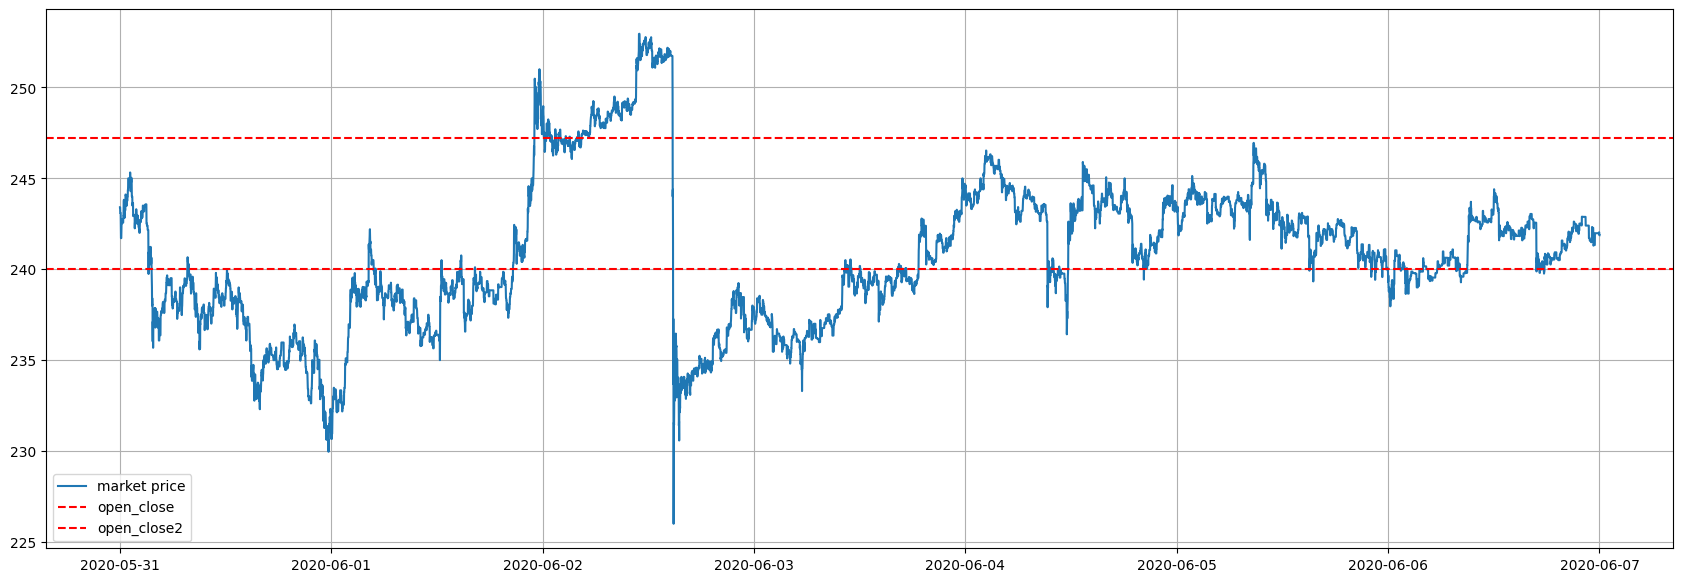

In [12]:
# Period of Simulations
period = ["2020-05-31","2020-06-07"]
data = historical_data.loc[period[0]+' 00:00:00':period[1]+' 00:00:00']

fig, axs = plt.subplots(1, 1, figsize=(21, 7))
axs.plot(data['close'], color='tab:blue', label='market price')
# axs.axhline(floor, color='darkgoldenrod', linestyle='--', label='floor')
axs.axhline(y=240, color='red', linestyle='--', label='open_close')
axs.axhline(y=247.2, color='red', linestyle='--', label='open_close2')
# axs.axhline(y=390, color='red', linestyle='--', label='open_close')
axs.grid()
axs.legend(loc='lower left')
plt.show()

In [15]:
period = ["2020-05-31","2020-06-07"]
data = historical_data.loc[period[0]+' 00:00:00':period[1]+' 00:00:00']
data['close'].max()/data['close'].min()

1.1192477876106195

Next we define a function that will
- Initiallize the main module + loading the data + definning the floor in a way that the open_close we get is the relevant price previously mentioned + define trigger_prices and the intervals
- Create a new directory "Files/From_"from period"_to_"to period"_open_close_at_"relevant price" + save the historical_data with the intervals of every price added
- Initiallize all the parameters for both protocols + add the trigger point price_to_ltv_limit + defining the first interval_old to be the first interval in the dataset stgy.historical_data
- Call data_dumper to create aave_results.csv and dydx_results.csv only with the headers
- Run through the code executing everything as discussed in the dev doc.

This function is useful because we can run simulations for different periods of times and relevant prices (just by using a list of periods and relevant prices and looping thorugh it) and saving the results in descriptive directories.

In [55]:
def run_sim(period, slippage, floor, pcg):
    global ocs
    # Initialize everything
    with open("Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    # period = ["2019-09-01","2019-12-31"]
    stgy.historical_data = historical_data.loc[period[0] + ' 00:00:00':period[1] + ' 00:00:00']
    # For vol updates we take all data up to the last date
    stgy.launch(config)
    # Load target_prices + intervals in stgy.historical_data
    # First we calculate weighted vol
    last_date = period[1] + ' 00:00:00'
    vol = stgy.parameter_manager.calc_vol(last_date, historical_data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    # Now we define prices and intervals given K and vol
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor, pcg)
    #########################
    # Save historical data with trigger prices and thresholds loaded
    # checking if the directory demo_folder
    # exist or not.
    if not os.path.exists("Files/From_%s_to_%s_open_close_at_%s" % (period[0], period[1], int(floor))):
        # if the demo_folder directory is not present
        # then create it.
        os.makedirs("Files/From_%s_to_%s_open_close_at_%s" % (period[0], period[1], int(floor)))
    stgy.historical_data.to_csv("Files/From_%s_to_%s_open_close_at_%s/stgy.historical_data.csv"
                                % (period[0], period[1], int(floor)))
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = 1000000 / stgy.historical_data['close'][initial_index]

    # AAVE
    stgy.aave.market_price = stgy.historical_data['close'][initial_index]

    # What is the price at which we place the collateral in AAVE given our initial_index?
    stgy.aave.entry_price = stgy.aave.market_price
    # We place 90% of staked as collateral and save 10% as a reserve margin
    stgy.aave.collateral_eth = round(stgy.stk * 0.9, 3)
    stgy.aave.collateral_eth_initial = round(stgy.stk * 0.9, 3)
    stgy.reserve_margin_eth = stgy.stk * 0.1
    # We calculate collateral and reserve current value
    stgy.aave.collateral_usdc = stgy.aave.collateral_eth * stgy.aave.market_price
    stgy.reserve_margin_usdc = stgy.aave.reserve_margin_eth * stgy.aave.market_price

    # What is the usdc_status for our initial_index?
    stgy.aave.usdc_status = True
    stgy.aave.debt = (stgy.aave.collateral_eth_initial * stgy.aave.entry_price) * stgy.aave.borrowed_percentage
    stgy.aave.debt_initial = (stgy.aave.collateral_eth_initial * stgy.aave.entry_price) * stgy.aave.borrowed_percentage
    # debt_initial
    stgy.aave.price_to_ltv_limit = round(stgy.aave.entry_price * stgy.aave.borrowed_percentage / stgy.aave.ltv_limit(),
                                         3)
    # stgy.total_costs = 104

    # DyDx
    stgy.dydx.market_price = stgy.historical_data['close'][initial_index]
    # stgy.dydx.interval_current = stgy.historical_data['interval'][initial_index]
    stgy.dydx.short_collateral = stgy.aave.debt
    stgy.dydx.short_equity = stgy.dydx.short_equity_calc()
    stgy.dydx.short_collateral_status = True
    
    print(stgy.trigger_prices['roof'],stgy.trigger_prices['start'],stgy.trigger_prices['floor'])
    print(stgy.dydx.market_price <= stgy.trigger_prices['start'])
    print((stgy.dydx.market_price <= stgy.trigger_prices['start']) and (stgy.dydx.market_price > stgy.trigger_prices['floor']))
    # print((stgy.dydx.market_price <= stgy.trigger_prices['start']) and (stgy.dydx.market_price > stgy.trigger_prices['floor']))
    if (stgy.dydx.market_price <= stgy.trigger_prices['start']):
        stgy.dydx.open_short(stgy)
    if ((stgy.dydx.market_price <= stgy.trigger_prices['start']) and (stgy.dydx.market_price > stgy.trigger_prices['floor'])):
        stgy.dydx.open_long(stgy)
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(period, floor)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(period, floor)
    ##################################
    # Run through dataset
    #########################
    # import time
    # # run simulations
    # starttime = time.time()
    # print('starttime:', starttime)
    # for i in range(initial_index, len(stgy.historical_data)):
    i = initial_index

    maker_fees_counter = []
    while (i < len(stgy.historical_data)):
        # for i in range(initial_index, len(stgy.historical_data)):
        # pass

        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        previous_market_price = stgy.historical_data["close"][i-1]
        market_price = stgy.historical_data["close"][i]
        #########################
        # Update parameters
        # First we update everything in order to execute scenarios with updated values
        # We have to update
        # AAVE: market_price, interval_current, lending and borrowing fees (and the diference),
        # debt value, collateral value and ltv value
        # DyDx: market_price, interval_current, notional, equity, leverage and pnl
        stgy.parameter_manager.update_parameters(stgy, market_price)
        ##############################
        stgy.parameter_manager.find_scenario(stgy, market_price, previous_market_price)
        ##############################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
            # stgy.total_costs = stgy.total_costs + stgy.dydx.funding_rates
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        # We write the data into the google sheet or csv file acording to sheet value
        # (sheet = True --> sheet, sheet = False --> csv)
        stgy.data_dumper.write_data(stgy,
                                    period, floor,
                                    sheet=False)
        #########################
        # we increment index by the time consumed in executing actions
        # i += time_used
        i += 1
    return maker_fees_counter

In [35]:
str(historical_data.index[0])

'2019-09-01 00:00:00'

In [14]:
data = historical_data.loc[periods_n_open_close[0][0][0]+' 00:00:00':periods_n_open_close[0][0][1]+' 00:00:00']

In [15]:
returns = data['close'].pct_change().dropna()
log_returns = np.log(data['close']) \
        - np.log(data['close'].shift(1))

In [30]:
std_ema_log_returns = log_returns.ewm(alpha=0.8, adjust=False).std().mean()
std_ema_returns = returns.ewm(alpha=0.8, adjust=False).std().mean()
mu_log_returns = log_returns.mean()
mu_abs_log_returns = abs(log_returns).mean()
std_ema_abs_log_returns = abs(log_returns).ewm(alpha=0.8, adjust=False).std().mean()
mu_log_returns_max = log_returns.max()
mu_log_returns_min = log_returns.min()
mu_returns = returns.mean()
mu_abs_returns = abs(returns).mean()
mu_returns_max = returns.max()
mu_returns_min = returns.min()

In [31]:
mu_returns_max, mu_returns_min

(0.01716814159292035, -0.034270575164515926)

In [2]:
K = 3
condition = (mu_abs_log_returns-K*std_ema_log_returns<log_returns)&(log_returns<mu_abs_log_returns+K*std_ema_log_returns)

NameError: name 'mu_abs_log_returns' is not defined

In [29]:
mu_abs_log_returns+K*std_ema_log_returns

0.00252015691537573

In [1]:
len(log_returns[condition]),len(log_returns),len(log_returns[condition])/len(log_returns)

NameError: name 'log_returns' is not defined

(array([3.800e+01, 4.800e+01, 3.500e+01, 4.000e+01, 3.700e+01, 4.000e+01,
        4.100e+01, 3.600e+01, 4.500e+01, 5.100e+01, 4.100e+01, 5.300e+01,
        5.400e+01, 2.400e+01, 5.800e+01, 3.900e+01, 5.900e+01, 7.100e+01,
        3.100e+01, 8.600e+01, 7.800e+01, 1.700e+01, 7.400e+01, 7.500e+01,
        1.300e+01, 9.000e+01, 8.600e+01, 1.800e+01, 8.500e+01, 1.500e+01,
        8.400e+01, 5.975e+03, 0.000e+00, 1.220e+02, 8.700e+01, 2.000e+00,
        8.600e+01, 9.000e+01, 6.000e+00, 8.200e+01, 6.700e+01, 2.100e+01,
        9.100e+01, 5.900e+01, 3.300e+01, 8.200e+01, 4.000e+01, 4.300e+01,
        6.600e+01, 3.700e+01, 5.700e+01, 5.100e+01, 4.100e+01, 5.000e+01,
        5.200e+01, 3.900e+01, 4.000e+01, 3.900e+01, 4.500e+01, 4.000e+01,
        3.100e+01, 4.200e+01, 3.700e+01, 3.800e+01, 3.700e+01, 3.400e+01,
        3.200e+01, 3.400e+01, 3.700e+01, 2.600e+01, 4.000e+01, 3.200e+01,
        3.100e+01, 2.300e+01, 2.100e+01, 2.300e+01, 2.500e+01, 2.000e+01,
        3.000e+01, 1.900e+01, 2.800e+0

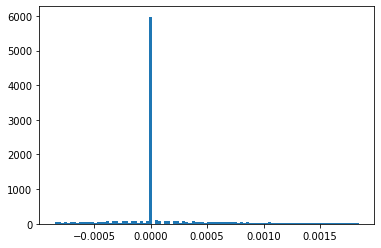

In [74]:
plt.hist(log_returns[condition], bins=100)

In [55]:
len(log_returns)

11521

Now let's define a list with some periods of time and relevant prices to use for calling the previous function and run several simulations at once.

In [45]:
periods_n_open_close = [[["2019-09-01","2019-12-31"],148], [["2019-09-01","2019-12-31"],185], 
                        [["2020-01-01","2020-05-01"],135]]#, [["2020-05-01","2020-09-01"],240]]
periods_n_open_close = [[["2019-09-01","2019-12-31"],185]]
periods_n_open_close = [[["2020-05-01","2020-09-01"],240]]

In [56]:
for period_n_open_close in periods_n_open_close:
    period = period_n_open_close[0]
    start = period_n_open_close[1]
    pcg = 0.05
    floor = start * (2/(2+pcg))
    slippage = 0.0005
    maker_fees_counter = run_sim(period, slippage, floor, pcg)

245.85365853658539 240.0 234.14634146341464
True
False


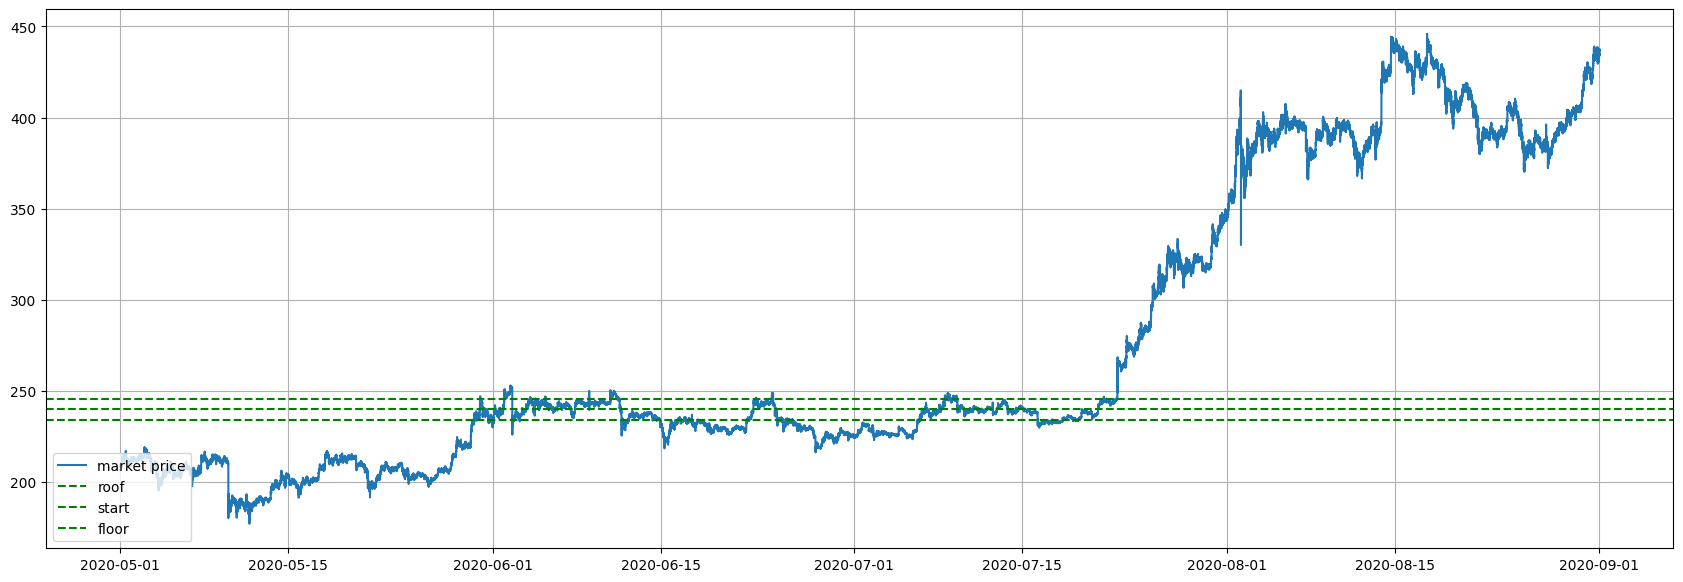

In [47]:
# Period of Simulations
period = periods_n_open_close[0][0]
data = historical_data.loc[period[0]+' 00:00:00':period[1]+' 00:00:00']

# roof, start, floor
start = periods_n_open_close[0][1]
pcg = 0.05
floor = start * (2/(2+pcg))
roof = floor * (1+pcg)

fig, axs = plt.subplots(1, 1, figsize=(21, 7))
axs.plot(data['close'], color='tab:blue', label='market price')
axs.axhline(y=roof, color='green', linestyle='--', label='roof')
axs.axhline(y=start, color='green', linestyle='--', label='start')
axs.axhline(y=floor, color='green', linestyle='--', label='floor')
axs.grid()
axs.legend(loc='lower left')
plt.show()

In [143]:
maker_fees_counter

[{'oc': 186.11, 'txs': 9, 'date': '2019-09-14 16:44:00'},
 {'oc': 187.22665999999998, 'txs': 8, 'date': '2019-10-11 06:36:00'},
 {'oc': 188.35001996000003, 'txs': 8, 'date': '2019-10-14 18:11:00'},
 {'oc': 189.48012007975998, 'txs': 8, 'date': '2019-10-26 03:02:00'},
 {'oc': 188.35001996000003, 'txs': 9, 'date': '2019-10-28 01:20:00'},
 {'oc': 187.22665999999998, 'txs': 8, 'date': '2019-10-29 10:52:00'},
 {'oc': 186.11, 'txs': 8, 'date': '2019-10-29 12:57:00'},
 {'oc': 185.0, 'txs': 8, 'date': '2019-10-29 14:51:00'},
 {'oc': 186.11, 'txs': 9, 'date': '2019-11-02 17:36:00'},
 {'oc': 187.22665999999998, 'txs': 8, 'date': '2019-11-04 16:08:00'},
 {'oc': 188.35001996000003, 'txs': 8, 'date': '2019-11-04 21:02:00'},
 {'oc': 189.48012007975998, 'txs': 8, 'date': '2019-11-06 01:38:00'},
 {'oc': 188.35001996000003, 'txs': 9, 'date': '2019-11-06 16:31:00'},
 {'oc': 187.22665999999998, 'txs': 8, 'date': '2019-11-07 08:56:00'},
 {'oc': 186.11, 'txs': 8, 'date': '2019-11-08 01:04:00'},
 {'oc': 185

In [144]:
len(maker_fees_counter)

20

In [ ]:
dydx_results = pd.read_csv("Files/From_2020-05-31_to_2020-06-07_open_close_at_240/dydx_results.csv")
dydx_results['total_stgy_pnl'][len(dydx_results)-1]

In [17]:
slippage = 0.0005
K_1 = 2
K_2 = 6
mu = 0.0004973569978282845
sigma = 0.0006742666391824819
floor = 240 / ((1+slippage)*(1+mu+K_1*sigma))
p_open_close_1 = floor * (1+slippage) * (1+mu+K_1*sigma)
p_open_close_2 = p_open_close_1 * (1+K_2/K_1/100)
floor, p_open_close_1, p_open_close_2

(239.4380835398584, 240.0, 247.20000000000002)

In [29]:
(1+slippage)*(1+mu+6*sigma)

1.0050452283113396

In [22]:
max_loss = 0.05
p_open_close_1 = floor * (1+slippage) * (1+mu+K_1*sigma)
oc1 = p_open_close_1
for i in range(1,5):
    globals()['oc'+str(i+1)] = oc1 * 1.01**i # jumps of 1%

In [18]:
p_open_close_1/p_open_close_2-1

-0.029126213592233108

## Extras

Let's define a function to count how many times a given price is cross given a dataset.

In [14]:
def cross_counter(data_set, price):
    crossed_down = 0
    crossed_up = 0
    index_up = []
    index_down = []
    for index in range(1,len(data_set)):
        previous_price = data_set['close'][index-1]
        current_price = data_set['close'][index]
        if previous_price <= price < current_price:
            crossed_up += 1
            index_up.append(index-1)
        elif previous_price >= price > current_price:
            crossed_down += 1
            index_down.append(index-1)
    return {'down':
                {'crossed_down': crossed_down,
                'index_down': index_down},
            'up':
                {'crossed_up': crossed_up,
                'index_up': index_up}}

In [15]:
# Period of Simulations
period = ["2020-05-01","2020-09-01"]
data_set = historical_data.loc[period[0]+' 00:00:00':period[1]+' 00:00:00']
price = 240

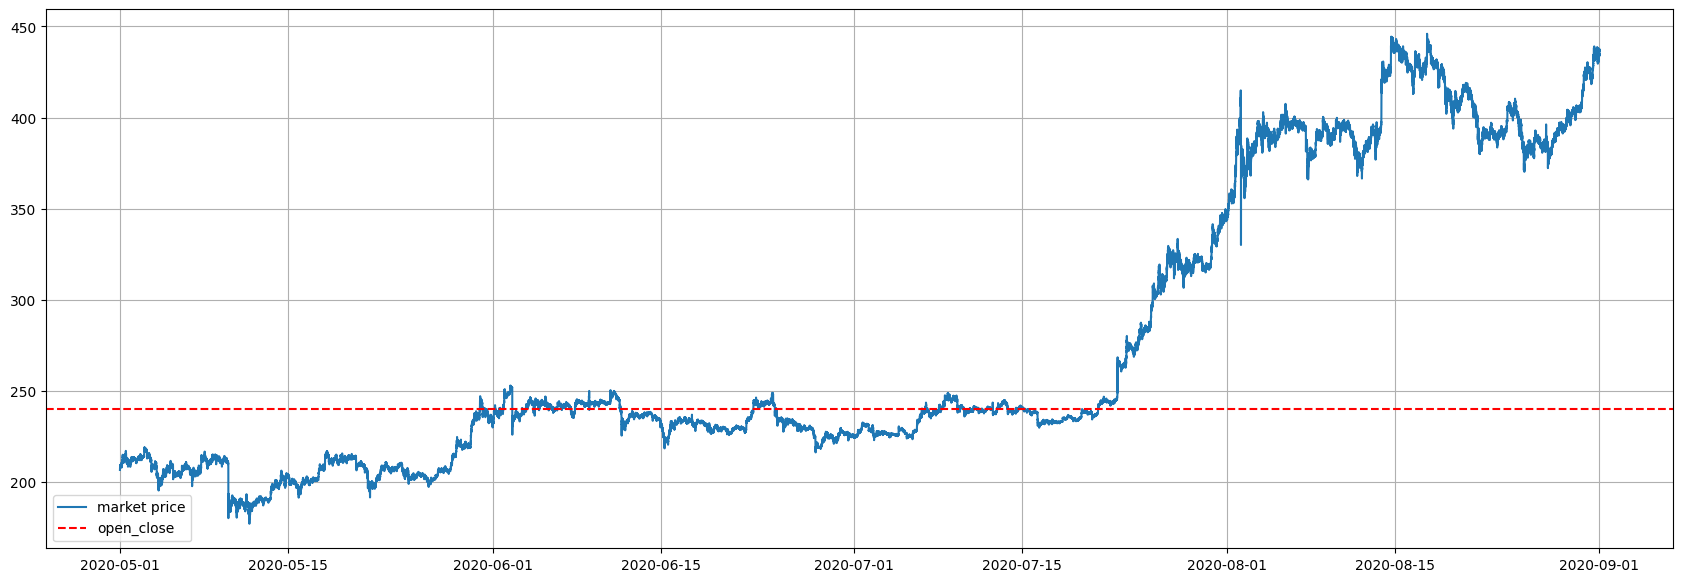

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(21, 7))
axs.plot(data_set['close'], color='tab:blue', label='market price')
# axs.axhline(floor, color='darkgoldenrod', linestyle='--', label='floor')
axs.axhline(y=240, color='red', linestyle='--', label='open_close')
# axs.axhline(y=185, color='red', linestyle='--', label='open_close')
# axs.axhline(y=390, color='red', linestyle='--', label='open_close')
axs.grid()
axs.legend(loc='lower left')
plt.show()

In [17]:
crosses = cross_counter(data_set, 240)

In [18]:
crosses['down']['crossed_down'] + crosses['up']['crossed_up']

312

In [61]:
dydx_results = pd.read_csv("Files/From_2020-05-01_to_2020-09-01_open_close_at_240/dydx_results.csv")

In [62]:
dydx_results.astype(bool).sum(axis=0)

market_price                    176910
I_current                       176910
I_old                           176910
entry_price                      53220
short_size                       53220
collateral                      176910
notional                         53375
equity                          176910
leverage                         53375
pnl                              53066
collateral_status               176910
short_status                     53220
order_status                    123690
withdrawal_fees                 176910
funding_rates                   176910
maker_taker_fees                133516
maker_fees_counter              133516
costs                              421
gas_fees                        176910
total_costs_from_aave_n_dydx    133516
total_stgy_pnl                  176910
index_of_mkt_price              176910
dtype: int64

Let's define a function to count down in which rows of the results a maker_fee is added. This will be helpful to analize the moments in which we close the short (therefore being able to calculate close_price - entry_price) and to compare if the amount of maker_fees is equal to the times the relevant price is crosses (both should coincide). 

In [70]:
def count_maker_fees_increment(data_set):
    index_of_maker_fee = []
    for index in range(1,len(data_set)):
        previous_maker_fee_counter = data_set['maker_fees_counter'][index-1]
        current_maker_fee_counter = data_set['maker_fees_counter'][index]
        if previous_maker_fee_counter < current_maker_fee_counter:
            index_of_maker_fee.append(index)
    return {'indexes': index_of_maker_fee}

In [72]:
results_maker_fee_counter= count_maker_fees_increment(dydx_results)

Let's count down how many indexes in which price crossed relevant price downwards coincide with indexes in which a maker fee was added. Same for price crossing relevant price upwards.

In [167]:
matches_up = 0
matches_down = 0
for index_up in crosses['up']['index_up']:
    if index_up in results_maker_fee_counter['indexes']:
        matches_up += 1
for index_down in crosses['down']['index_down']:
    if index_down in results_maker_fee_counter['indexes']:
        matches_down += 1

In [170]:
matches_up, matches_down, matches_up + matches_down

(155, 136, 291)

In [173]:
len(crosses['up']['index_up']), len(crosses['down']['index_down'])

(156, 156)

So almost all indexes for which price goes above relevant price coincide with indexes in which a maker fee was added. It means that in order to get the rows in which we close the short, we can use index_up.

Let's now calculate the average value of close_price - entry_price to have a notion of for how much usually we miss and a notion of an average amount of loss coming from closing late.

First of all note that if we look at rows of results for indexes between [index_up -2, index_up+2] we realise that 
- entry_price and short_size can be found at index_up -1
- close_price is market_price in index = index_up

In [176]:
i = 1
index = crosses['up']['index_up'][i]
dydx_results.iloc[index-2:index+2][['market_price', 'I_current','I_old','short_size','entry_price','pnl','maker_fees_counter','total_stgy_pnl']]

,market_price,I_current,I_old,short_size,entry_price,pnl,maker_fees_counter,total_stgy_pnl
43393,240.70,infty,minus_infty,0.000,0.00,0.0000,0,-2.879624
43394,239.74,minus_infty,infty,-4334.634,239.74,0.0000,1,-522.470891
43395,240.94,infty,minus_infty,0.000,0.00,-5201.5608,2,-6246.223689
43396,240.86,infty,minus_infty,0.000,0.00,0.0000,2,-6246.222332


Let's calculate the difference close - open and the cost for each time we close the short (ie for every index_up).

In [177]:
diff = []
cost = []
# we dont start the loop at i = 0 because the data_set started below open_close
# so the first time price crossed open_close doesnt matter bc we didnt assume have the short position open
for i in range(1,len(crosses['up']['index_up'])):
    index_up = crosses['up']['index_up'][i]
    if index_up in results_maker_fee_counter['indexes']:
        entry_price = dydx_results.iloc[index-1]['entry_price']
        close_price = dydx_results.iloc[index]['market_price']
        short_size = dydx_results.iloc[index-1]['short_size']
        diff.append(close_price-entry_price)
        cost.append(short_size * (close_price-entry_price))

In [180]:
np.mean(diff), np.mean(cost)

(1.1999999999999886, -5201.560799999951)